## **Assignment 2 - Numerical Optimization & Large Scale Linear Algebra**

This notebook contains the implementation of all tasks from the second assignment for the Numerical Optimization and Large Scale Linear Algebra course

### **• Task 1**

<u>**Description**</u>

**Tune the algorithm for accuracy of classification. Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.**

<u>**Solution**</u>

Import some packages

In [1]:
# Import required packages

import openpyxl
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Ignoring warnings
warnings.simplefilter("ignore", UserWarning)

Create a custom color map to be used for viewing digit images

In [2]:
# Defining the color mappings
color_mapping = np.array(
    [
        [1.0000, 1.0000, 1.0000],
        [0.8715, 0.9028, 0.9028],
        [0.7431, 0.8056, 0.8056],
        [0.6146, 0.7083, 0.7083],
        [0.4861, 0.6111, 0.6111],
        [0.3889, 0.4722, 0.5139],
        [0.2917, 0.3333, 0.4167],
        [0.1944, 0.1944, 0.3194],
        [0.0972, 0.0972, 0.1806],
        [0, 0, 0.0417],
    ]
)

# Creating the custom colormap
custom_colormap = LinearSegmentedColormap.from_list(
    "custom_colormap", color_mapping, N=256
)

Define a function for showing digit images

In [ ]:
def show_image(image_vector, custom_colormap, ax=None):
    """
    This function is used to show an image representing a digit.

    :param image_vector: A 256-vector representing an image
    :param custom_colormap: The colormap to use
    :param ax: The subplot axis to draw on
    :return: None
    """

    # Reshaping
    image_vector_reshaped = image_vector.reshape(16, 16)

    # Translating vector to become non-negative
    image_vector_reshaped = image_vector_reshaped - np.min(image_vector_reshaped)

    # Scaling to interval [0, 20]
    image_vector_reshaped = (20 / np.max(image_vector_reshaped)) * image_vector_reshaped

    # Checking if subplot axis is provided
    if ax is not None:

        # Displaying the image
        ax.imshow(image_vector_reshaped, cmap=custom_colormap, vmin=0, vmax=20)

    else:

        # Displaying the image
        plt.imshow(image_vector_reshaped, cmap=custom_colormap, vmin=0, vmax=20)

        # Showing
        plt.show()

Load the training and test data

In [4]:
# Loading the training and test data
training_images_df = pd.read_excel(
    "project_svd_handwritten/data.xlsx", sheet_name="azip", header=None
)
training_labels_df = pd.read_excel(
    "project_svd_handwritten/data.xlsx", sheet_name="dzip", header=None
)
test_images_df = pd.read_excel(
    "project_svd_handwritten/data.xlsx", sheet_name="testzip", header=None
)
test_labels_df = pd.read_excel(
    "project_svd_handwritten/data.xlsx", sheet_name="dtest", header=None
)

# Converting the dataframe to numpy arrays
training_digit_images = training_images_df.to_numpy()
training_digit_labels = training_labels_df.to_numpy()
test_digit_images = test_images_df.to_numpy()
test_digit_labels = test_labels_df.to_numpy()

# Reshaping
training_digit_labels = training_digit_labels.reshape(-1)
test_digit_labels = test_digit_labels.reshape(-1)

Separate the digit classes - matrices

In [5]:
# Setting a dictionary keeping the matrices of the different digit classes
digit_classes = {}

# Iterating over the digits 0-9
for digit in range(10):

    # Extracting the relative matrix
    digit_classes[digit] = {
        "initial_matrix": training_digit_images[:, training_digit_labels == digit]
    }

Show the first digit image for each digit class

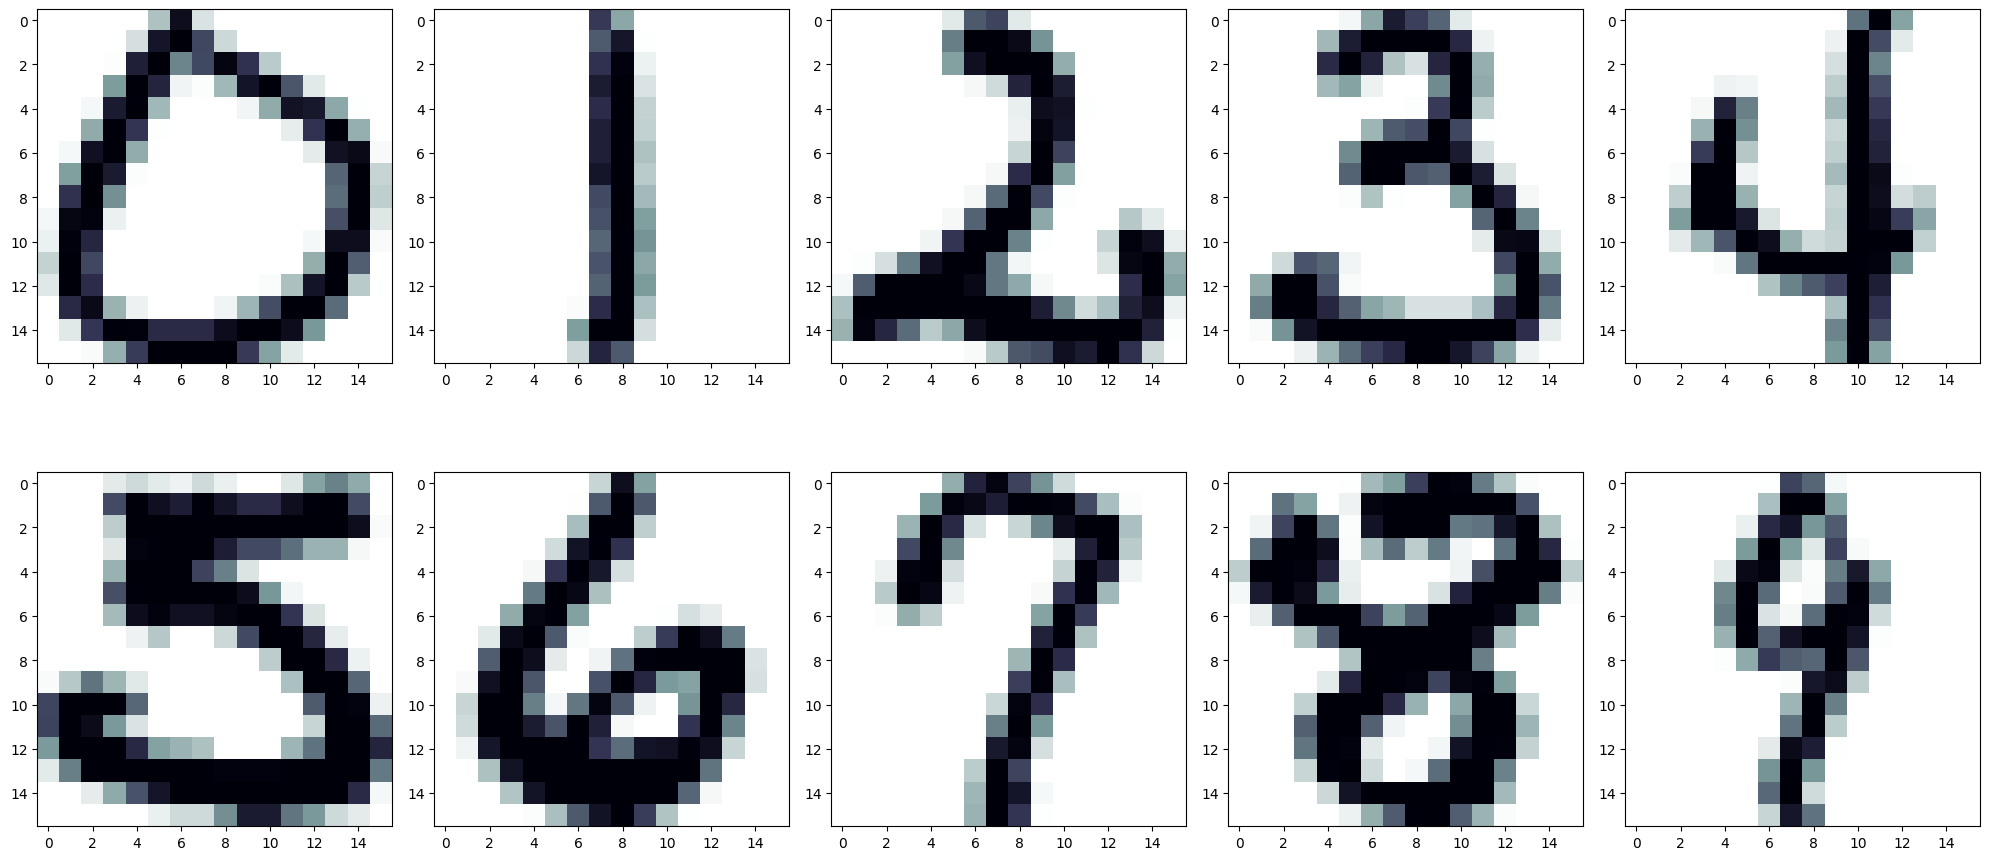

In [11]:
# Creating the subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Flattening axes for easy iteration
axes = axes.flatten()

# Iterating over the digit classes
for key, value in digit_classes.items():

    # Getting the image
    digit_image = value["initial_matrix"][:, 0]

    # Selecting the corresponding subplot
    ax = axes[key]

    # Drawing the image
    show_image(digit_image, custom_colormap, ax)

# Showing the 3-digit images
plt.tight_layout()
plt.show()

Calculate the SVD components for the matrices of all digit classes as follows:

$$A_i = U_i \Sigma_i V_i^T$$

where:

- $A_i$ represents the i-digit class matrix
- $U_i$ represents a orthogonal matrix containing the left singular vectors in columns
- $\Sigma_i$ represents a diagonal matrix containing the singular values
- $V_i^T$ represents a orthogonal matrix containing the right singular vectors in rows

In [6]:
# Iterating over the digit classes
for key, value in digit_classes.items():

    # Computing the SVD components (U, S, V.T)
    left_singular_vectors, singular_values, right_singular_vectors = np.linalg.svd(
        value["initial_matrix"]
    )

    # Updating
    digit_classes[key]["left_singular_vectors"] = left_singular_vectors
    digit_classes[key]["singular_values"] = singular_values
    digit_classes[key]["right_singular_vectors"] = right_singular_vectors

Define a function for computing the Euclidean norm of the residual vector of the least squares problems, for a specific digit class and unknown digit image, as follow:

$$\| (I - U_{ik} U_{ik}^T)z \|_2$$

where:

- $I$ represents a diagonal matrix of ones
- $U_{ik}$ represents K left singular vectos for the i-digit class
- $U_{ik}^T$ represents the transpose of $U_{ik}$
- $z$ represents a test / unknown digit image

In [ ]:
def compute_residual_norm(left_singular_vectors, unknown_digit):
    """
    This function is used to compute the Euclidean norm of the residual
    vector for a specific digit class and unknown digit image.

    :param left_singular_vectors: The left singular vectors of the digit classes
    :param unknown_digit: The vector of the unknown digit image
    :return: The Euclidean norm of the residual vector
    """

    # Computing the first argument of the residual formula
    argument_1 = np.eye(left_singular_vectors.shape[0])

    # Computing the second argument of the residual formula
    argument_2 = left_singular_vectors @ left_singular_vectors.T

    # Normalizing the unknown digit image
    unknown_digit = unknown_digit / np.linalg.norm(unknown_digit)

    # Generating the residual vector
    residual = (argument_1 - argument_2) @ unknown_digit

    # Computing the Euclidean norm
    residual_norm = np.linalg.norm(residual)

    return residual_norm

Define a function for classifying unknown/test digit images using the Euclidean norm of the residual vector of the least squares problems

In [8]:
def classify_digit_images(classes_left_singular_vectors, test_digit_images):
    """
    This function is used to classify the test digit images based on some
    provided left singular vectors of the digit classes and by computing the
    corresponding residual norms.

    :param classes_left_singular_vectors: The left singular vectors of the digit classes
    :param test_digit_images: The digit images to be classified
    :return: The predicted digits and the residual norms
    """

    # Setting two lists keeping the predictions and the residual norms
    predicted_digits = []
    residual_norms = []

    # Iterating over the test digit images
    for test_digit_image in np.hsplit(test_digit_images, test_digit_images.shape[1]):

        # Setting some variables to track the min residual norm and the relative digit label
        min_residual_norm = float("inf")
        predicted_digit = None

        # Setting a list for keeping the current residual norms
        current_residual_norms = []

        # Iterating over the digit classes
        for key, value in classes_left_singular_vectors.items():

            # Computing the residual norm
            residual_norm = compute_residual_norm(value, test_digit_image)

            # Appending the residual norm
            current_residual_norms.append(residual_norm)

            # Checking if we have a lower residual norm
            if residual_norm < min_residual_norm:

                # Updating
                min_residual_norm = residual_norm
                predicted_digit = key

        # Updating
        predicted_digits.append(predicted_digit)
        residual_norms.append(current_residual_norms)

    return np.array(predicted_digits), np.array(residual_norms)

Define a function for keeping a certain number of left singular vectors in each digit class

In [ ]:
def truncate_left_singular_vectors(digit_classes, number_base_vectors, type):
    """
    This function is used to keep a specific number of left singular
    vectors from each digit class.

    :param digit_classes: The SVD components of the digit classes
    :param number_base_vectors: The numbers of left singular vectors to keep
    :param type: What type of left singular vectors to use (initial or kernelized)
    :return: The final left singular vectors of the digit classes
    """

    # Setting a list for keeping the truncated left singular vectors of the digit classes
    classes_left_singular_vectors = {}

    # Iterating over the digit classes
    for key, value in digit_classes.items():

        # Checking what to use
        if type == "initial":

            # Truncating
            classes_left_singular_vectors[key] = value["left_singular_vectors"][
                :, : number_base_vectors[key]
            ]

        else:

            # Truncating
            classes_left_singular_vectors[key] = value["kernel_left_singular_vectors"][
                :, : number_base_vectors[key]
            ]

    return classes_left_singular_vectors

Tuning - Test of keeping different number of left singular vectors (basis) in the digit classes

In [15]:
# Setting a list for test of keeping different number of left singular vectors
numbers_base_vectors = list(range(5, 21))

# Setting a list for keeping the relative results
results = {}

# Iterating over the numbers of vectors to keep
for number_base_vectors in numbers_base_vectors:

    # Truncating the left singular vectors of the digit classes
    classes_left_singular_vectors = truncate_left_singular_vectors(
        digit_classes, [number_base_vectors] * 10, "initial"
    )

    # Classifying
    predicted_digits, residual_norms = classify_digit_images(
        classes_left_singular_vectors, test_digit_images
    )

    # Updating
    results[number_base_vectors] = {
        "predictions": predicted_digits,
        "residual_norms": residual_norms,
    }

Compute the classification scores for all the classifiers with different number of basis vectors (5-20)

In [16]:
# Setting a list keeping the classification scores to show
show_classification_scores = []

# Setting a list keeping the content of the accuracy table to show
show_accuracies = [("# Basis Vectors", "Accuracy (%)")]

# Setting a list keeping the confusion matrices
show_confusion_matrices = []

# Iterating over the tuning results
for key, value in results.items():

    # Computing the classification scores for the current 'left singular vectors' config
    show_classification_scores.append(
        (
            f"{key} Basis Vectors",
            classification_report(test_digit_labels, value["predictions"]),
        )
    )

    # Computing the accuracy
    show_accuracies.append(
        (
            f"{key}",
            round(accuracy_score(test_digit_labels, value["predictions"]) * 100, 1),
        )
    )

    # Computing the confusion matrix
    show_confusion_matrices.append(
        (
            f"{key} Basis Vectors",
            confusion_matrix(test_digit_labels, value["predictions"]),
        )
    )

Show the accuracies as a function of the number of basis vectors

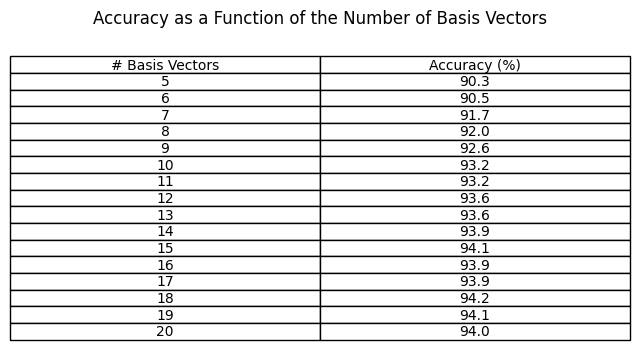

In [18]:
# Creating a figure
plt.figure(figsize=(8, 4))

# Creating a table
plt.table(
    cellText=show_accuracies[1:],
    colLabels=show_accuracies[0],
    cellLoc="center",
    loc="center",
)

# Setting plot paramters
plt.title(
    "Accuracy as a Function of the Number of Basis Vectors",
    pad=15,
    loc="center",
)
plt.axis("tight")
plt.axis("off")

# Showing the table
plt.show()

As shown in the table above, after testing various numbers of basis vectors (ranging from 5 to 20), the highest accuracy is achieved with 18 basis vectors across all digit classes, reaching 94.2%, which is slightly higher than the others

### **• Task 2**

<u>**Description**</u>

**Check if all digits are equally easy or difficult to classify. Also look at some of the difficult ones, and see that in many cases they are very badly written.**

<u>**Solution**</u>

Show the classification scores/reports of all the classifiers with different number of basis vectors (5-20)

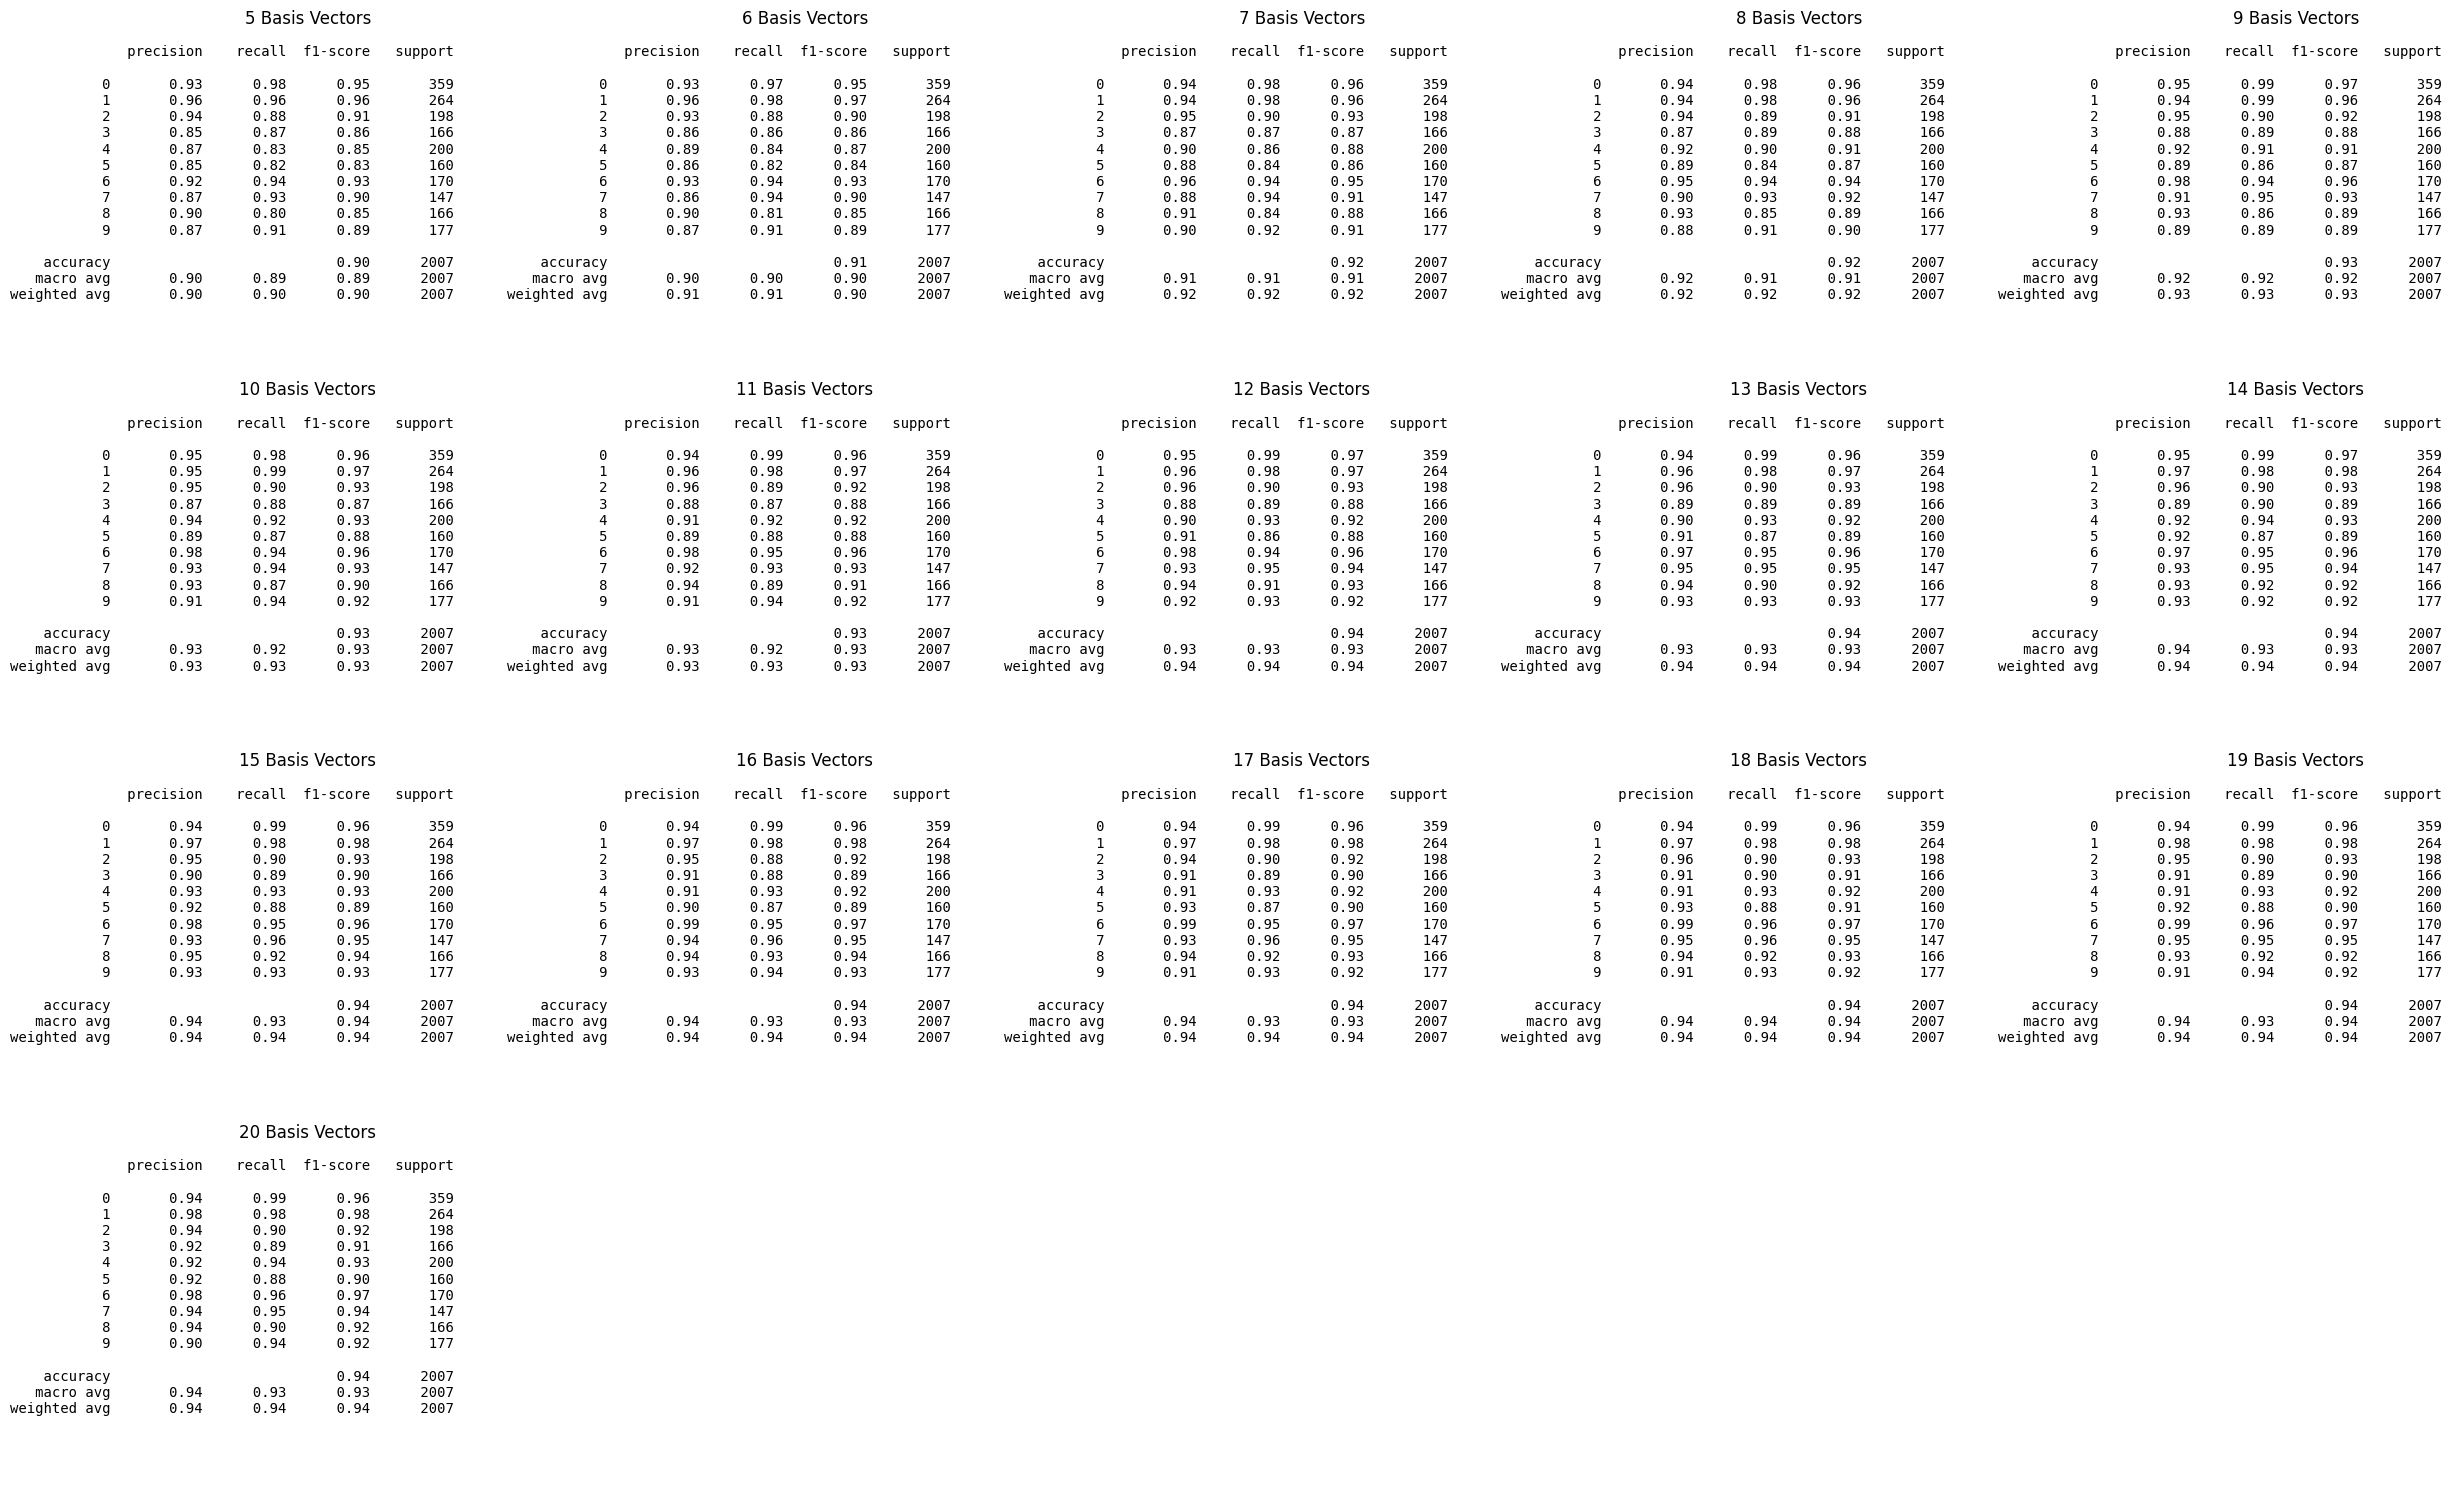

In [19]:
# Creating the subplots
fig, axes = plt.subplots(4, 5, figsize=(25, 15))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Iterating over the axes and the classification reports
for ax, (title, report) in zip(axes, show_classification_scores):

    # Showing the classification report
    ax.text(
        0,
        0.55,
        report,
        fontsize=10,
        family="monospace",
        verticalalignment="center",
        horizontalalignment="left",
    )

    # Setting plot parameters
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(title, loc="center", x=0.8)

# Removing axes for any unused subplot
axes[16].axis("off")
axes[17].axis("off")
axes[18].axis("off")
axes[19].axis("off")

# showing the figure
plt.tight_layout()
plt.show()

Show the confusion matrix of all the classifiers with different number of basis vectors (5-20)

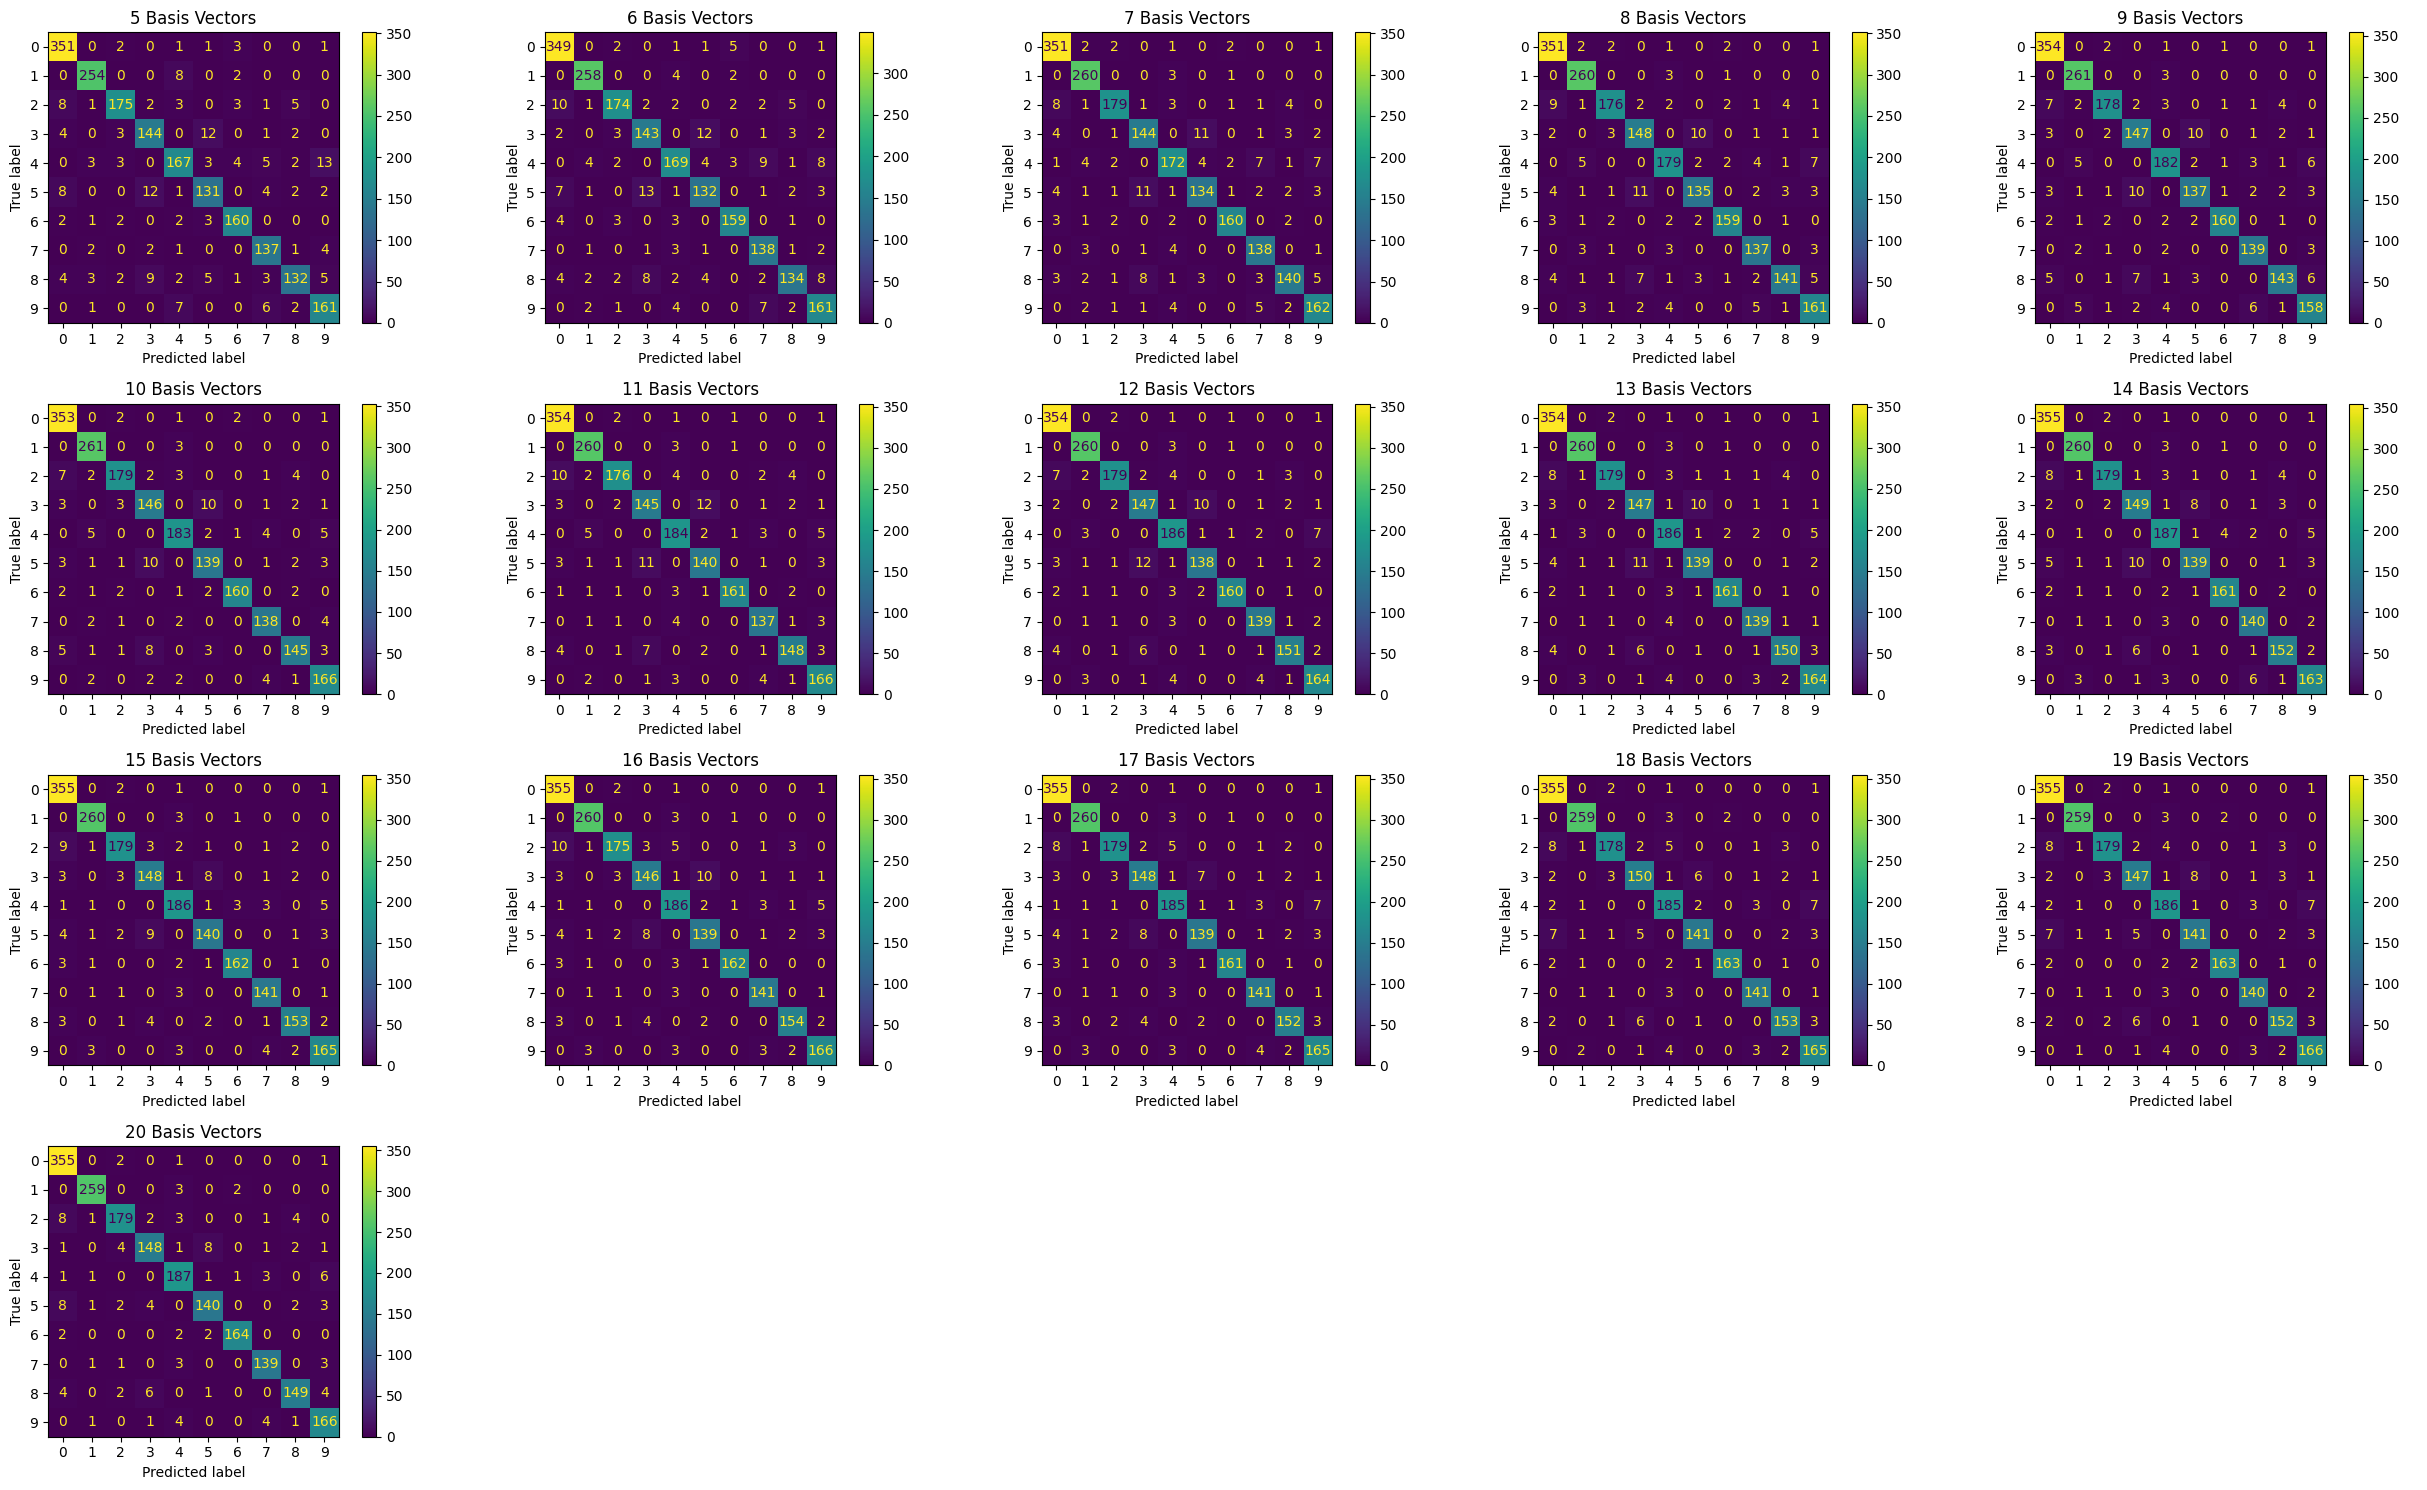

In [20]:
# Creating the subplots
fig, axes = plt.subplots(4, 5, figsize=(25, 15))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Iterating over the axes and the confusion matrices
for ax, (title, conf_matrix) in zip(axes, show_confusion_matrices):

    # Creating a display form for the confusion matrix
    conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Showing the confusion matrix
    conf_matrix_display.plot(ax=ax, cmap="viridis")

    # Setting a subplot title
    ax.set_title(title)

# Removing axes for any unused subplot
axes[16].axis("off")
axes[17].axis("off")
axes[18].axis("off")
axes[19].axis("off")

# showing the confusion matrices
plt.tight_layout()
plt.show()

Calculate the average of the residuals of all unknown digits (0-9) in all the different base vector numbers in the digit classes

In [21]:
# Setting a dictionary for keeping the average residuals for all the unknown digits
avg_residual_norms = {}

# Iterating over the digits
for digit in range(10):

    # Setting a list to keep the residuals of the current digit
    digit_arrays = []

    # Iterating over the results of the different classifiers
    for value in results.values():

        # Updating
        digit_arrays.append(value["residual_norms"][test_digit_labels == digit])

    # Getting the average residuals
    avg_residual_norms[digit] = np.mean(digit_arrays, axis=0)

Show the average of the residuals of all unknown digits (0-9)

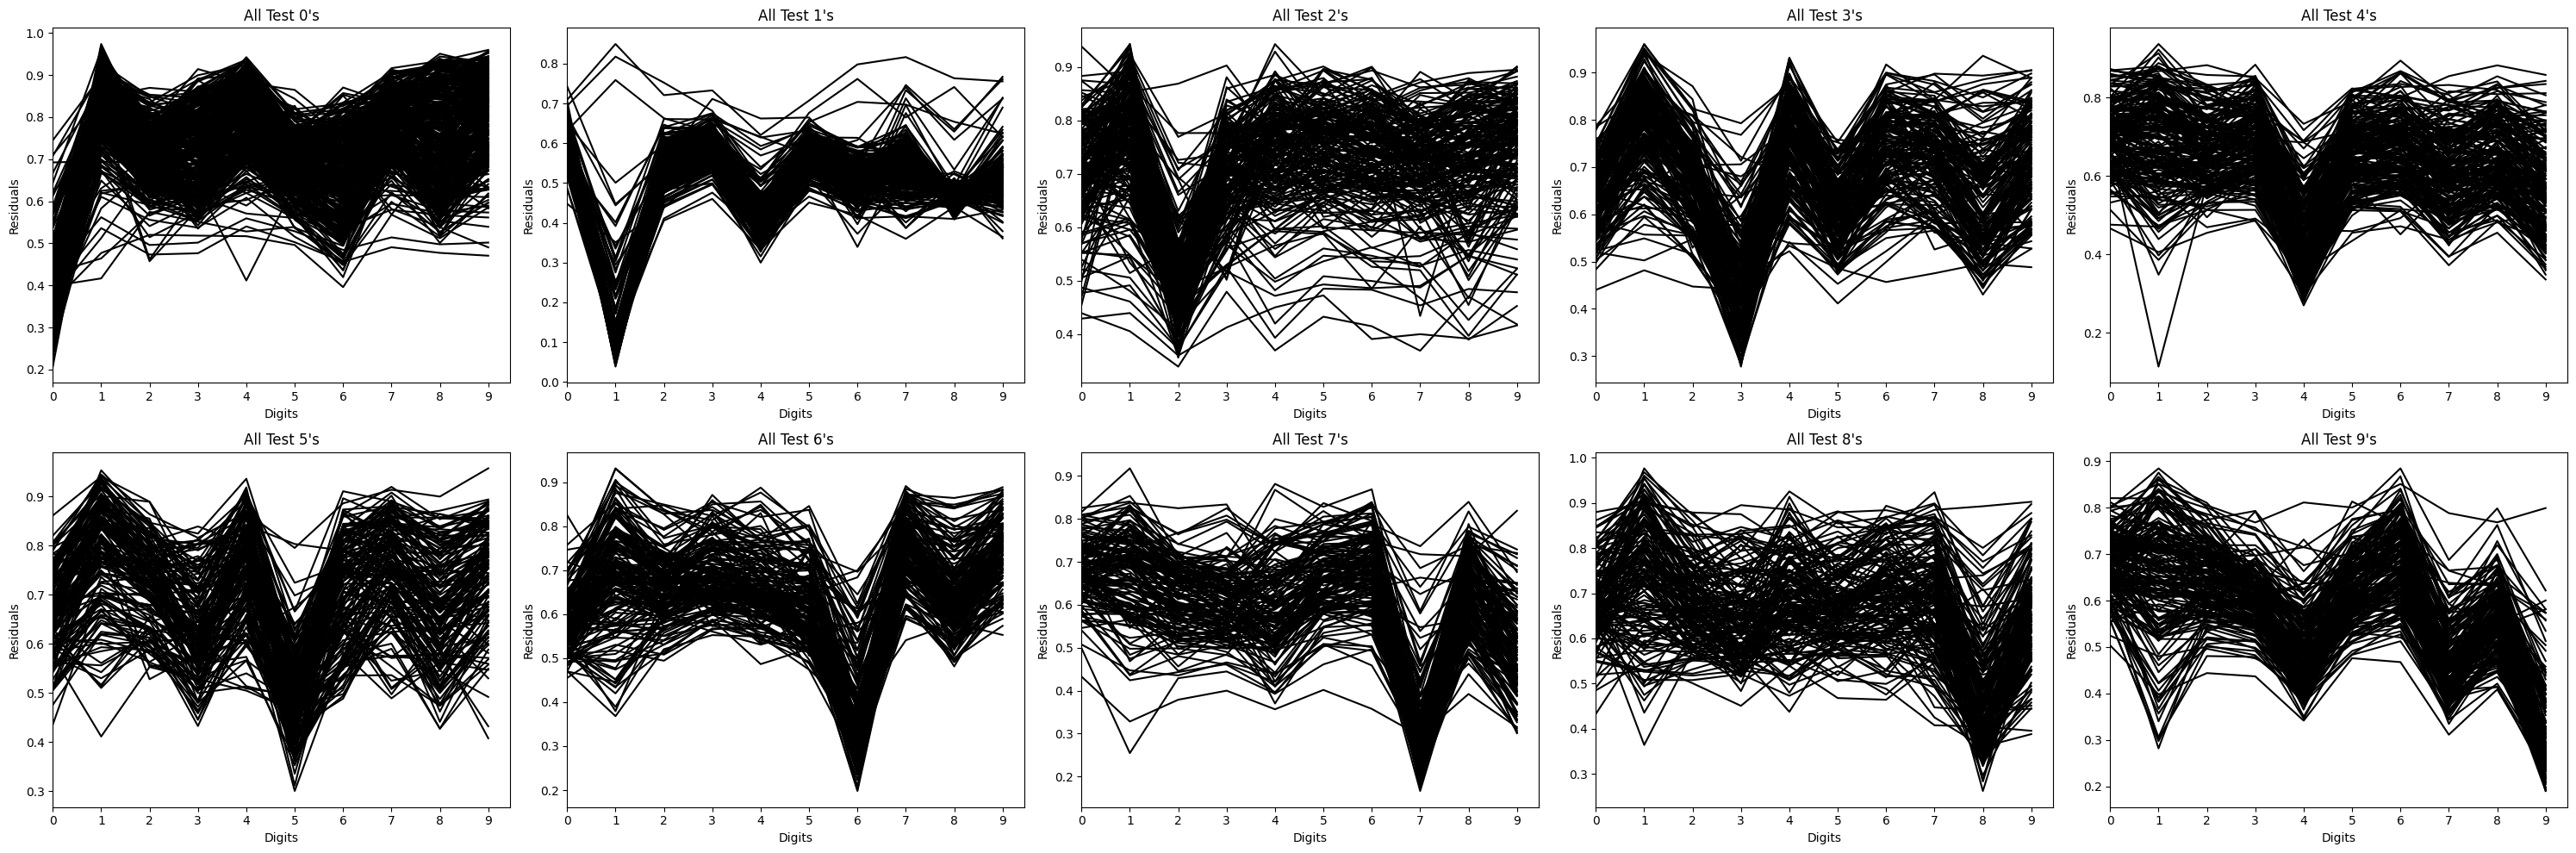

In [26]:
# Creating a figure with 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Iterating over the average residual norms of the digits
for key, value in avg_residual_norms.items():

    # Selecting the corresponding subplot
    ax = axes[key]

    # Iterating over the rows
    for row in range(value.shape[0]):

        # Adding the line
        ax.plot(value[row], color="black")

    # Setting subplot parameters
    ax.set_title(f"All Test {key}'s")
    ax.set_xlabel("Digits")
    ax.set_ylabel("Residuals")
    ax.set_xticks(range(10))
    ax.set_xlim(left=0)

# Showing the plots
plt.tight_layout()
plt.show()

After analyzing the first two visuals displaying the classification report and confusion matrices for different classifiers, we can confirm that the classifier with 18 basis vectors performs slightly better, as previously mentioned. Additionally, not all digits are equally easy to classify, as some are more challenging and yield lower scores. Specifically, digits 3 and 5 are more frequently misclassified than others, with classifiers often assigning them to incorrect digit classes.

From the visual illustrating the average residuals of unknown digits across digit classes for various numbers of basis vectors, we observe that most digits are primarily represented by the basis of their respective digit class. However, in some cases, their residuals are lower for other digit classes, indicating that they are better represented by those bases, leading to misclassifications. For example, digit 3 is more likely to be misclassified as digit 5 or 8, while digit 5 is more often misclassified as digit 3 or 8.

Below, we visualize some misclassified test images of digits 3 and 5 by the classifier using 18 basis vectors to determine whether they are poorly written

Retrieve the misclassified 3-digit and 5-digit images from the test dataset using 18 basis vectors in all digit classes

In [27]:
# Getting the unknown 3-digit images that have been incorrectly classified
misclassifications_3 = test_digit_images[
    :, (results[18]["predictions"] != test_digit_labels) & (test_digit_labels == 3)
]

# Getting the unknown 5-digit images that have been incorrectly classified
misclassifications_5 = test_digit_images[
    :, (results[18]["predictions"] != test_digit_labels) & (test_digit_labels == 5)
]

print(
    f"There are {misclassifications_3.shape[1]} 3-digit images that have been incorrectly classified"
)
print(
    f"There are {misclassifications_5.shape[1]} 5-digit images that have been incorrectly classified"
)

There are 16 3-digit images that have been incorrectly classified
There are 19 5-digit images that have been incorrectly classified


Show the misclassified 3-digit images

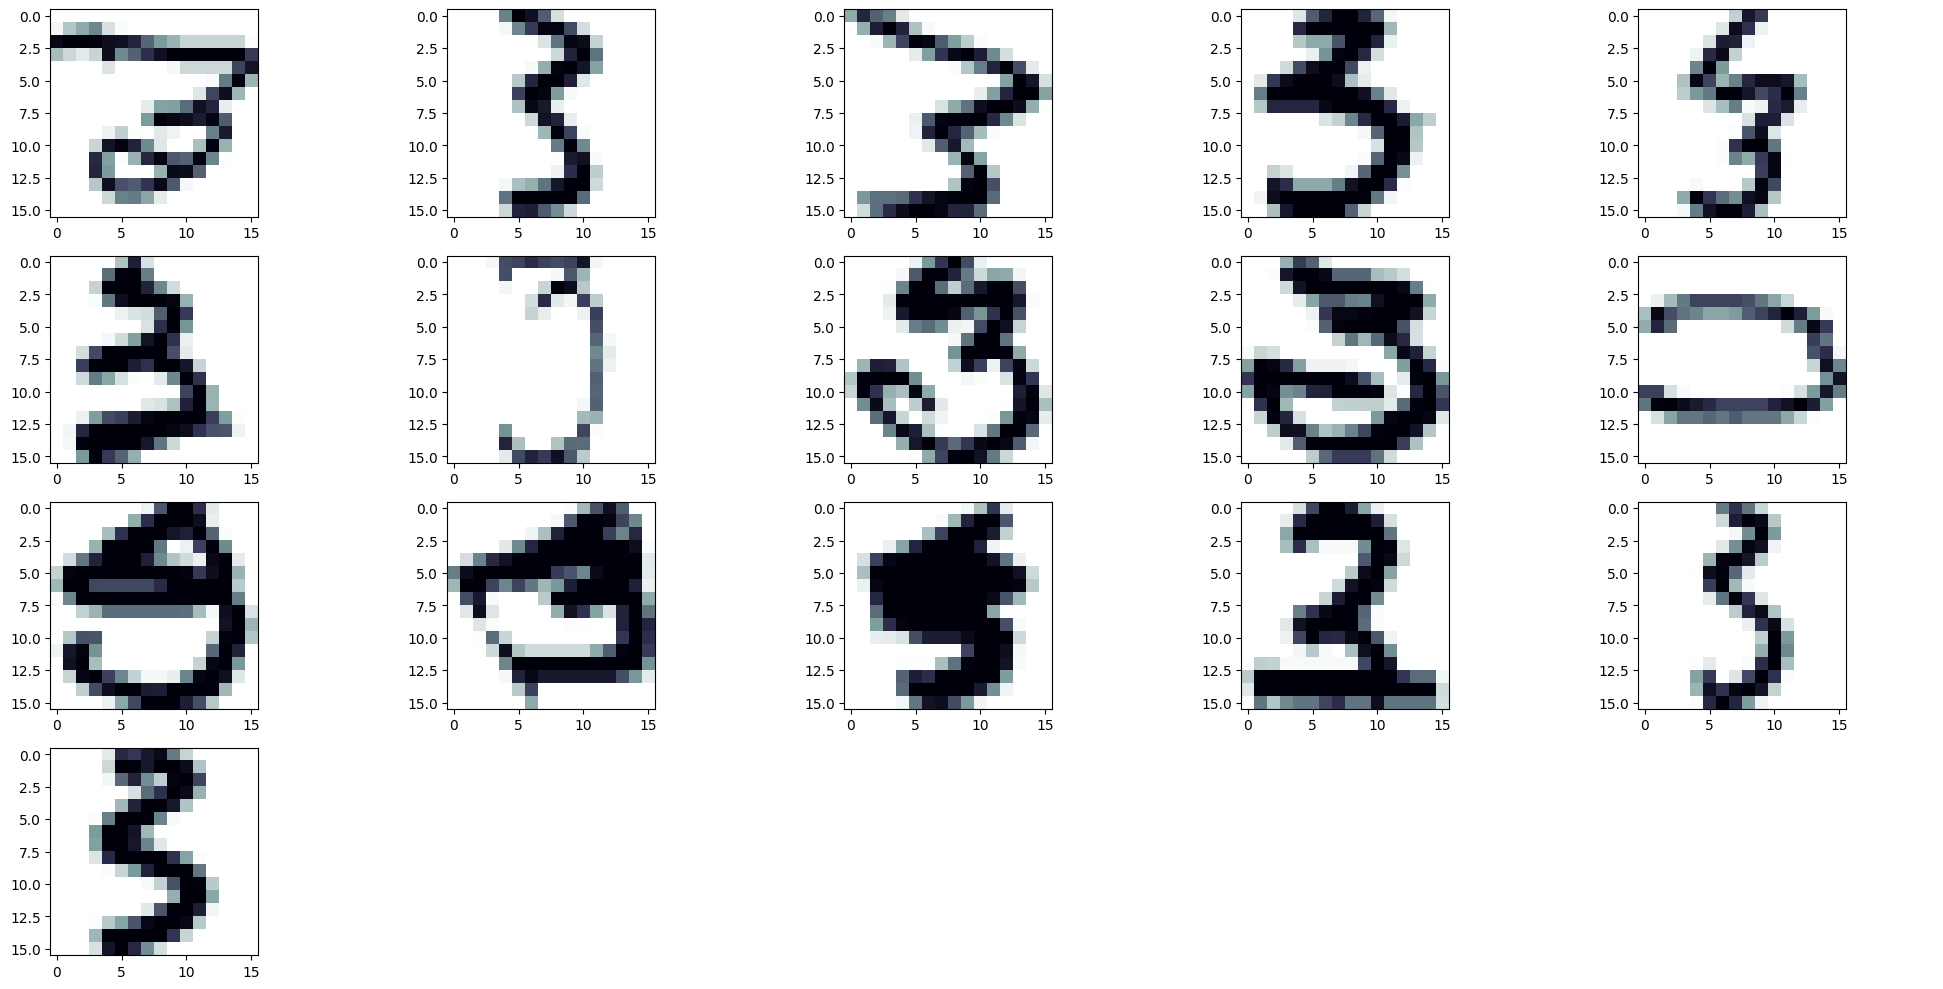

In [29]:
# Creating the subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 10))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Iterating over the 3-digit images
for index, digit_3_image in enumerate(
    np.hsplit(misclassifications_3, misclassifications_3.shape[1])
):

    # Selecting the corresponding subplot
    ax = axes[index]

    # Drawing the 3-digit image
    show_image(digit_3_image, custom_colormap, ax)

# Removing axes for any unused subplot
axes[16].axis("off")
axes[17].axis("off")
axes[18].axis("off")
axes[19].axis("off")

# Showing the 3-digit images
plt.tight_layout()
plt.show()

Show the misclassified 5-digit images

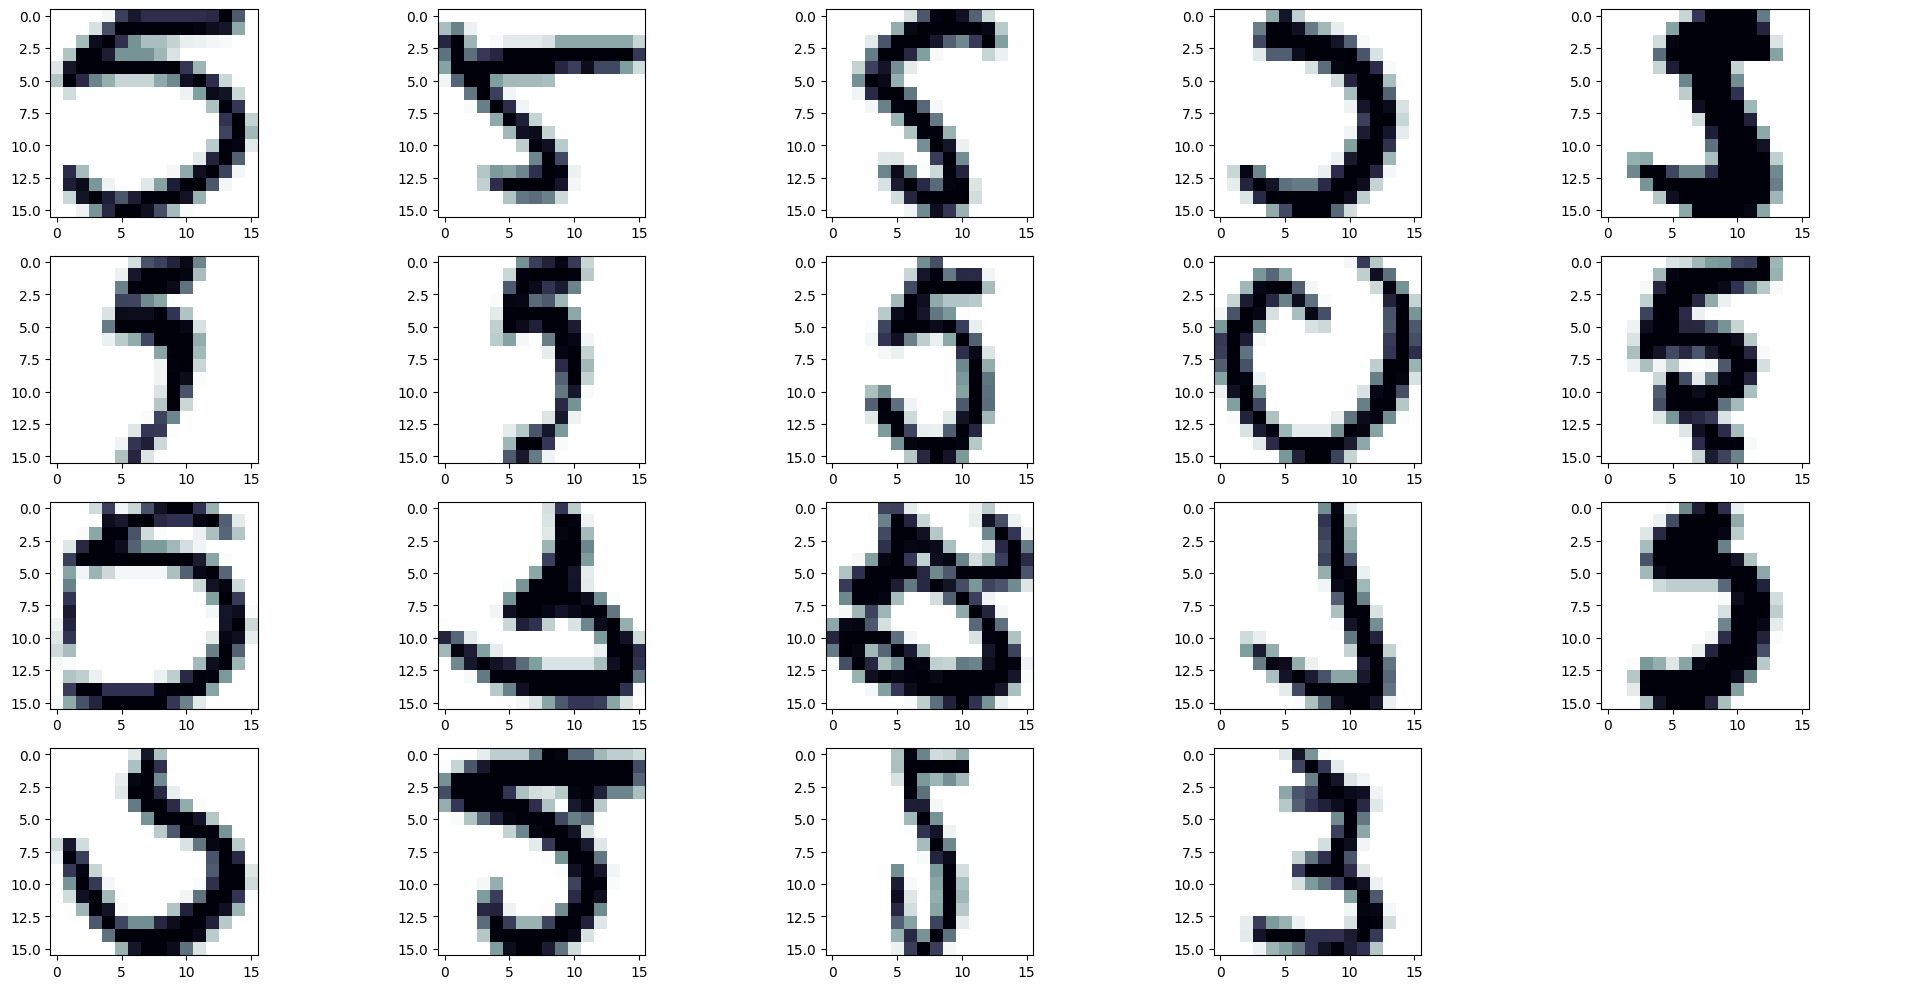

In [30]:
# Creating the subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 10))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Iterating over the 5-digit images
for index, digit_5_image in enumerate(
    np.hsplit(misclassifications_5, misclassifications_5.shape[1])
):

    # Selecting the corresponding subplot
    ax = axes[index]

    # Drawing the 5-digit image
    show_image(digit_5_image, custom_colormap, ax)

# Removing axes for any unused subplot
axes[19].axis("off")

# Showing the 5-digit images
plt.tight_layout()
plt.show()

From the images above, we confirm that a significant factor contributing to the misclassification by the classifier(s) is that many of the incorrectly classified digits are poorly written, making it difficult for the classifier to predict the correct digit label

### **• Task 3**

<u>**Description**</u>

**Check the singular values of the different classes. Is it motivated to use different numbers of basis vectors for different classes? If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.**

<u>**Solution**</u>

In this task, I will accomplish two objectives: first, I will determine the optimal number of basis vectors for each digit class by analyzing the singular value curves and the relative reconstruction error. Second, I will experiment by varying the number of basis vectors (fewer than 18) for one digit class while keeping the others constant (18)

Show the curves of the singular values of all the digit classes

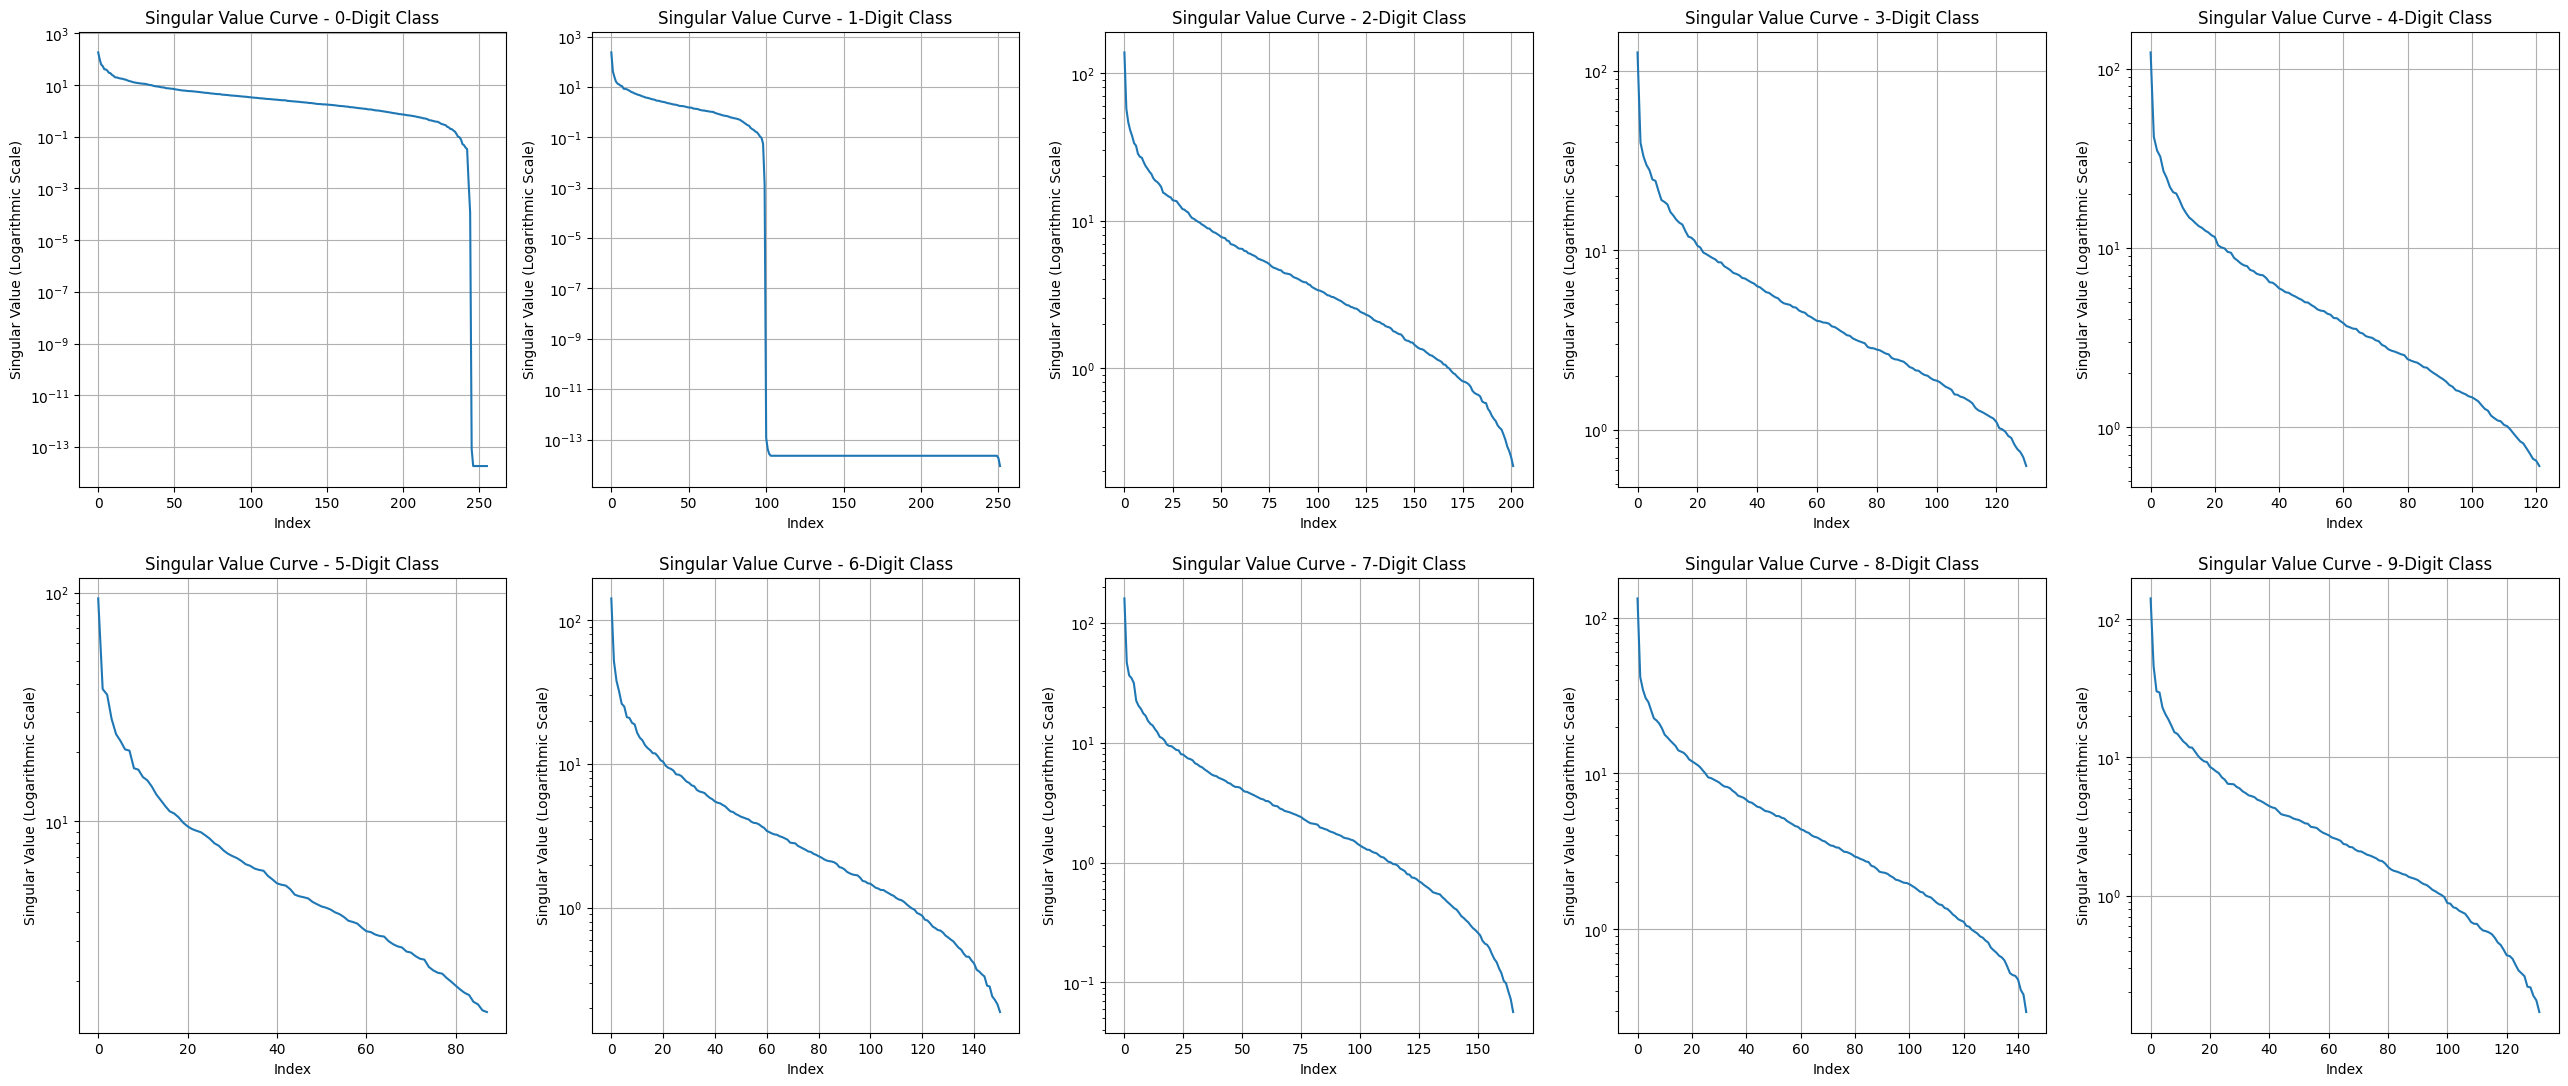

In [ ]:
# Creating the subplots
fig, axes = plt.subplots(2, 5, figsize=(32, 13))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Itearating over the digit classes
for digit, value in digit_classes.items():

    # Selecting the corresponding subplot
    ax = axes[digit]

    # Showing the curve of the current singular values in logarithmic  scale
    ax.semilogy(value["singular_values"])

    # Setting plot parameters
    ax.set_xlabel("Index")
    ax.set_ylabel("Singular Value (Logarithmic Scale)")
    ax.set_title(f"Singular Value Curve - {digit}-Digit Class")
    ax.grid()

# Showing
plt.show()

From the plots above, we can confirm that the optimal number of basis vectors for each digit class is where the singular values shift from a sharp decrease to a slower decline. Now, let's numerically determine the optimal values by minimizing the relative reconstruction error as follows:

$$\frac{\|A_i - A_{ik}\|_F}{\|A_i\|_F} = \sqrt{1 - \frac{\sum_{j=1}^k S_{ij}^2}{\sum_{j=1}^r S_{ij}^2}}$$


where:

- $\|A_i - A_{ik}\|_F$ represents the forbenius norm of the reconstruction error by keeping only the k first left singular vectors in i-digit class
- $\|A_i\|_F$ represents the forbenius norm of the i-digit class matrix

Find numerically the best number of basis vectors for the digit classes minimizing the relative reconstruction error. As a threshold i chose 0.1

In [45]:
# Setting up a list keeping the best number of basis vectors for all the digit classes
best_numbers_basis_vectors = []

# Iterating over the digit classes
for digit, value in digit_classes.items():

    # Computing the squared sums for different number of singular values
    squared_cumulative_sum = np.cumsum(value["singular_values"] ** 2)

    # Computing the total squared sum of all the singular values
    squared_sum = np.sum(value["singular_values"] ** 2)

    # Computing the reconstruction error
    reconstruction_error = np.sqrt(
        np.clip(1 - (squared_cumulative_sum / squared_sum), 0, None)
    )

    # Getting the best number of basis vectors for the current digit class
    best_number_basis_vectors = np.argmax(reconstruction_error <= 0.1) + 1

    # Updating
    best_numbers_basis_vectors.append(best_number_basis_vectors.item())

Show the best number of basis vectors for all the digit classes by minimizing the relative reconstruction error

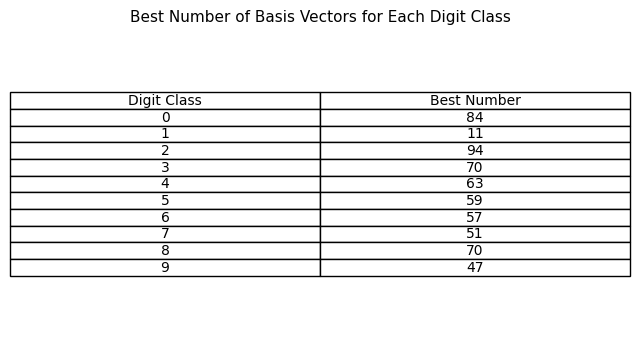

In [46]:
# Creating a figure
plt.figure(figsize=(8, 4))

# Creating the table
plt.table(
    colLabels=["Digit Class", "Best Number"],
    cellText=[
        [f"{index}", value] for index, value in enumerate(best_numbers_basis_vectors)
    ],
    cellLoc="center",
    loc="center",
)

# Setting plot paramters
plt.axis("tight")
plt.axis("off")
plt.title(
    "Best Number of Basis Vectors for Each Digit Class", loc="center", fontsize=11
)

# Showing the table
plt.show()

Classify the test digit images based on these optimal base vectors and show the perfomance

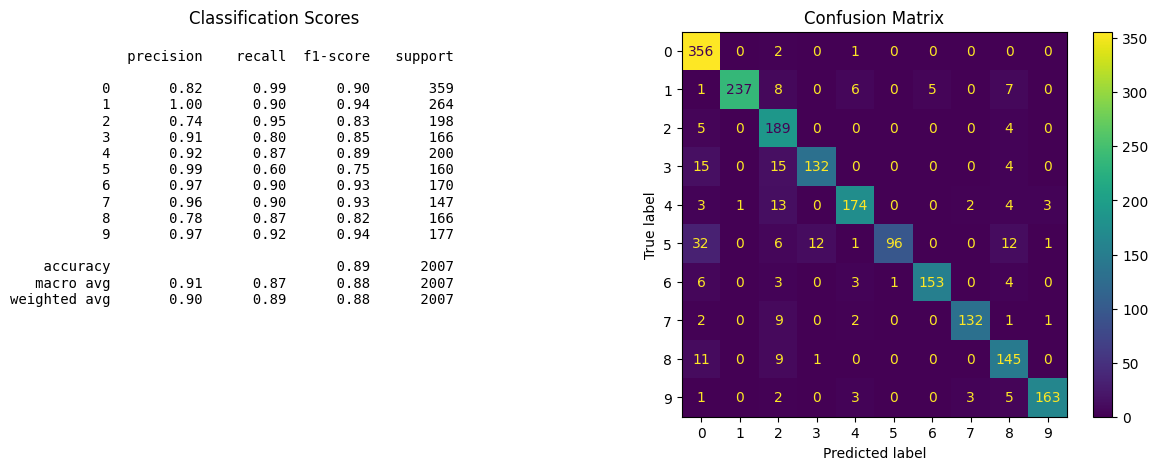

In [34]:
# Truncating the left singular vectors of the digit classes
classes_left_singular_vectors = truncate_left_singular_vectors(
    digit_classes, best_numbers_basis_vectors, "initial"
)

# Classifying
predicted_digits, _ = classify_digit_images(
    classes_left_singular_vectors, test_digit_images
)

# Creating the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Iterating over the axes
for index, ax in enumerate(axes):

    # Checking in which axis to draw
    if index == 0:

        # Showing the classification report
        ax.text(
            0,
            0.6,
            classification_report(test_digit_labels, predicted_digits),
            fontsize=10,
            family="monospace",
            verticalalignment="center",
            horizontalalignment="left",
        )

        # Setting subplot parameters
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_title("Classification Scores", loc="center", fontsize=12)

    else:

        # Creating a display form for the confusion matrix
        conf_matrix_display = ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix(test_digit_labels, predicted_digits)
        )

        # Showing the confusion matrix
        conf_matrix_display.plot(ax=ax, cmap="viridis")

        # Setting a subplot title
        ax.set_title("Confusion Matrix", fontsize=12)

# Showing
plt.show()

As we can see, selecting the optimal number of basis vectors for each digit class by analyzing singular values and minimizing the relative reconstruction error, using a threshold of 0.1, results in improved performance

Now, I will run tests using fewer than 18 basis vectors in certain digit classes to evaluate whether the performance improves

Define a function for predicting the digit labels using different base vectors

In [49]:
def test_different_base_vectors(base_vectors, digit_classes, test_digit_images):
    """
    This function is used to predict the label of the test digit images using
    predefined base vectors.

    :param base_vectors: The number of basis vectors to use in each digit class
    :param digit_classes: The SVD components of the digit classes
    :test_digit_images: The test images
    :return: The predictions
    """

    # Truncating the left singular vectors of the digit classes
    classes_left_singular_vectors = truncate_left_singular_vectors(
        digit_classes, base_vectors, "initial"
    )

    # Classifying
    predicted_digits, _ = classify_digit_images(
        classes_left_singular_vectors, test_digit_images
    )

    return predicted_digits

After conducting multiple experiments with fewer basis vectors in a single digit class, I present the following results

In [50]:
# Some random base vector configurations to test
base_vectors_to_test = [
    ["All with 18", 18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
    ["0-Digit with 13", 13, 18, 18, 18, 18, 18, 18, 18, 18, 18],
    ["1-Digit with 11", 18, 11, 18, 18, 18, 18, 18, 18, 18, 18],
    ["2-Digit with 14", 18, 18, 14, 18, 18, 18, 18, 18, 18, 18],
    ["3-Digit with 16", 18, 18, 18, 16, 18, 18, 18, 18, 18, 18],
    ["4-Digit with 10", 18, 18, 18, 18, 10, 18, 18, 18, 18, 18],
    ["5-Digit with 17", 18, 18, 18, 18, 18, 17, 18, 18, 18, 18],
    ["6-Digit with 12", 18, 18, 18, 18, 18, 18, 12, 18, 18, 18],
    ["7-Digit with 13", 18, 18, 18, 18, 18, 18, 18, 13, 18, 18],
    ["8-Digit with 15", 18, 18, 18, 18, 18, 18, 18, 18, 15, 18],
    ["9-Digit with 17", 18, 18, 18, 18, 18, 18, 18, 18, 18, 17],
]


# Iterating over the different base vectors configuration
for config in base_vectors_to_test:

    # Predicting
    predictions = test_different_base_vectors(
        config[1:], digit_classes, test_digit_images
    )

    # Showing results
    print(
        f"{config[0]} -> Accuracy: {accuracy_score(test_digit_labels, predictions) * 100} %"
    )

All with 18 -> Accuracy: 94.17040358744396 %
0-Digit with 13 -> Accuracy: 94.31988041853513 %
1-Digit with 11 -> Accuracy: 94.22022919780767 %
2-Digit with 14 -> Accuracy: 93.62232187344294 %
3-Digit with 16 -> Accuracy: 93.97110114598904 %
4-Digit with 10 -> Accuracy: 92.52615844544096 %
5-Digit with 17 -> Accuracy: 94.07075236671649 %
6-Digit with 12 -> Accuracy: 93.72197309417041 %
7-Digit with 13 -> Accuracy: 93.87144992526159 %
8-Digit with 15 -> Accuracy: 93.92127553562531 %
9-Digit with 17 -> Accuracy: 94.22022919780767 %


From the results above, we can see that there are cases where using fewer than 18 basis vectors in a single digit class leads to better performance than the 94.1704% achieved with 18 basis vectors across all classes. Additionally, conducting further experiments with fewer basis vectors in multiple digit classes, and not only one, could potentially yield even better results

### **• Optional Task 1**

<u>**Description**</u>

**In order to save operations in the test phase, implement a two-stage algorithm: In the first stage compare the unknown digit only to the first singular vector in each class. If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above. Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?**

<u>**Solution**</u>

Here, we will develop a two-stage classification algorithm. In the first stage, if the residual of a test image using only the first singular vector of a digit class is significantly lower than the others, it will be classified accordingly. Otherwise, it will proceed to the second stage, where residuals will be computed using all singular vectors, and the image will be assigned to the class with the lowest residual.

The goal is to optimize the testing phase by maximizing the use of the first stage, reducing computational cost. To achieve this, we will define a threshold for how much lower the minimum residual should be compared to the second lowest in the first stage to avoid proceeding to the next stage while maintaining classification accuracy similar to using all basis vectors. In this approach, all digit classes have 18 basis vectors.

To determine whether to proceed to the next stage, the following condition is applied:

$$\frac{\text{second\_lowest\_residual}}{\text{lowest\_residual}} > \text{threshold}$$

Define a function implementing the two-stage classification algorithm

In [51]:
def classify_digit_images_two_stages(
    classes_left_singular_vectors, test_digit_images, threshold
):
    """
    This function is used to classify the test digit images based on some
    provided left singular vectors of the digit classes and by computing the
    corresponding residual norms. It applies a two-step algorithm where in
    first uses only the first left singular vector and if necessary it uses
    all of them.

    :param classes_left_singular_vectors: The left singular vectors of the digit classes
    :param test_digit_images: The test digit images to be classified
    :param threshold: The threshold to use to check if stage 2 is necessary
    :return: The predicted digits
    """

    # Setting up a list keeping the predictions
    predicted_digits = []

    # Setting up a counter for the frequency of the first stage
    first_stage_counter = 0

    # Iterating over the test digit images
    for test_digit_image in np.hsplit(test_digit_images, test_digit_images.shape[1]):

        # Setting a list for keeping the current residual norms
        current_residual_norms = []

        # Iterating over the digit classes
        for key, value in classes_left_singular_vectors.items():

            # Computing the residual norm using only the first left singular vector
            residual_norm = compute_residual_norm(value[:, :1], test_digit_image)

            # Appending the residual norm
            current_residual_norms.append((key, residual_norm))

        # Sorting
        current_residual_norms.sort(key=lambda pair: pair[1])

        # Checking to proceed to the next stage or not
        if (current_residual_norms[1][1] / current_residual_norms[0][1]) > threshold:

            # Updating
            first_stage_counter += 1

            # Updating
            predicted_digits.append(current_residual_norms[0][0])

        else:

            # Setting some variables to track the min residual norm and the relative digit label
            min_residual_norm = float("inf")
            predicted_digit = None

            # Iterating over the left singular vectors of the digit classes
            for key, value in classes_left_singular_vectors.items():

                # Computing the residual norm
                residual_norm = compute_residual_norm(value, test_digit_image)

                # Checking if we have a lower residual norm
                if residual_norm < min_residual_norm:

                    # Updating
                    min_residual_norm = residual_norm
                    predicted_digit = key

            # Updating
            predicted_digits.append(predicted_digit)

    return np.array(predicted_digits), first_stage_counter

Retain the first 18 left singular vectors for each digit class

In [52]:
# Truncating the left singular vectors of the digit classes
best_classes_left_singular_vectors = truncate_left_singular_vectors(
    digit_classes, [18] * 10, "initial"
)

Tune the threshold parameter

In [53]:
# Setting some thresholds to check
thresholds = np.arange(1, 3.1, 0.1)

# Setting up two list for keeping the accuracies and the frequencies of the first stage
accuracies = []
first_stage_frequencies = []

# Iterating over the thresholds
for threshold in thresholds:

    # Classifying
    predicted_digits, first_stage_frequency = classify_digit_images_two_stages(
        best_classes_left_singular_vectors, test_digit_images, threshold
    )

    # Computing the accuracy
    accuracy = accuracy_score(test_digit_labels, predicted_digits)

    # Updating
    accuracies.append(accuracy)
    first_stage_frequencies.append(first_stage_frequency)

Show the accuracy and the times the first stage was used as function of the threshold parameter

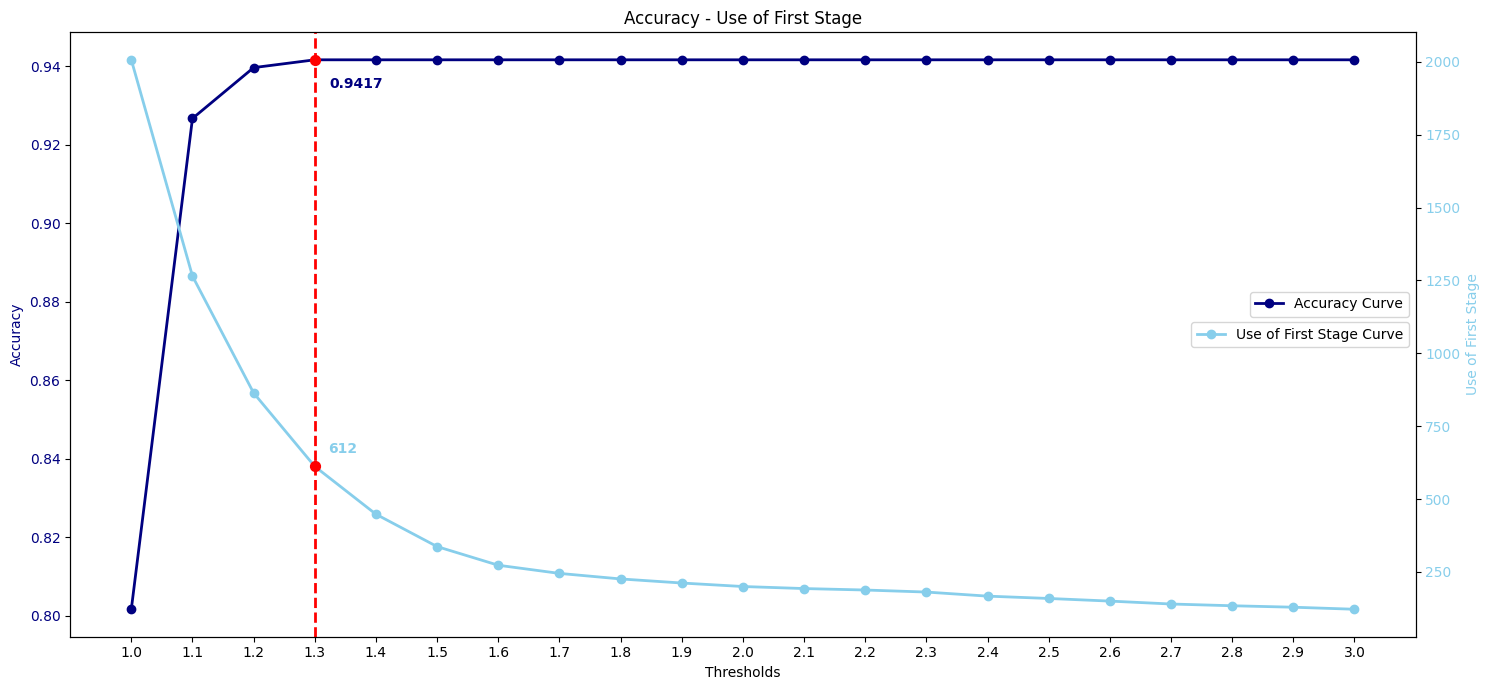

In [54]:
# Creating a figure
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plotting the first line
ax1.plot(
    thresholds,
    accuracies,
    color="navy",
    marker="o",
    linestyle="-",
    linewidth=2,
    label="Accuracy Curve",
)

# Setting some plot parameters
ax1.set_xlabel("Thresholds")
ax1.set_ylabel("Accuracy", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")
ax1.set_xticks(thresholds)
ax1.legend(loc="center right", bbox_to_anchor=(1, 0.55))

# Adding a vertical line
ax1.axvline(x=1.3, color="red", linestyle="--", linewidth=2)

# Annotating the intersection point
ax1.annotate(
    f"{accuracies[3]:.4f}",
    (1.3, accuracies[3]),
    textcoords="offset points",
    xytext=(30, -20),
    ha="center",
    color="navy",
    fontsize=10,
    fontweight="bold",
)

# Highlighting the intersection point
ax1.scatter(1.3, accuracies[3], color="red", s=50, zorder=3)

# Creating the second line sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(
    thresholds,
    first_stage_frequencies,
    color="skyblue",
    marker="o",
    linestyle="-",
    linewidth=2,
    label="Use of First Stage Curve",
)

# Setting some plot parameters
ax2.set_ylabel("Use of First Stage", color="skyblue")
ax2.tick_params(axis="y", labelcolor="skyblue")
ax2.legend(loc="center right", bbox_to_anchor=(1, 0.5))

# Annotating the intersection point
ax2.annotate(
    f"{first_stage_frequencies[3]}",
    (1.3, first_stage_frequencies[3]),
    textcoords="offset points",
    xytext=(20, 10),
    ha="center",
    color="skyblue",
    fontsize=10,
    fontweight="bold",
)

# Highlighting the intersection point
ax2.scatter(1.3, first_stage_frequencies[3], color="red", s=50, zorder=3)

# Setting a title
plt.title("Accuracy - Use of First Stage")

# Showing
fig.tight_layout()
plt.show()

From the chart above, we can see that the lowest tested threshold that maintains the same performance as using all 18 basis vectors for computing residual norms and classifying test digit images is 1.3. This threshold achieves the exact same accuracy while reducing the use of the second stage by 612 instances out of 2007, thereby lowering computational cost

Of course, using a slightly lower threshold would further reduce computational cost but at the expense of a slight drop in accuracy, as shown in the plot. If a minor performance loss is acceptable in exchange for greater computational efficiency, a smaller threshold can be used accordingly

### **• Task 4**

<u>**Description**</u>

**Try SVD with Kernels.**

<u>**Solution**</u>

In this approach, we first construct the kernel matrix for each digit class, apply SVD, and then follow the same methodology as before, but now operating in the transformed kernel feature space. Consequently, the test digit images must be represented and projected onto the new feature space of each digit class

Define a function to center a kernel matrix using the following formula:

$$KernelMatrix_{centered} = KernelMatrix - 1_{nxn}KernelMatrix - KernelMatrix1_{nxn} + 1_{nxn}KernelMatrix1_{nxn}$$

where:

- $1_{nxn}$ represents a nxn matrix with $\frac{1}{n}$ as value

In [93]:
def center_kernel_matrix(kernel_matrix):
    """
    This function is used to center a kernel matrix.

    :param kernel_matrix: A kernel matrix to center
    :return: The centered kernel matrix
    """

    # Getting the number of rows
    rows = kernel_matrix.shape[0]

    # Setting up a matrix to center the kernel matrix
    matrix_one_rows = np.ones((rows, rows)) / rows

    # Centering the kernel matrix
    centered_kernel_matrix = (
        kernel_matrix
        - matrix_one_rows @ kernel_matrix
        - kernel_matrix @ matrix_one_rows
        + matrix_one_rows @ kernel_matrix @ matrix_one_rows
    )

    return centered_kernel_matrix

Define a function for centering the kernel vector of a test image using the following formula:


$$KernelVector_{centered} = KernelVector - ColumnMean_{KernelMatrix} - Mean_{KernelVector} + Mean_{KernelMatrix}$$

where:

- $kernelMatrix$ represents the kernel matrix of the digit class onto which the test image is projected

In [94]:
def center_test_kernel_vector(test_kernel_vector, kernel_matrix):
    """
    This function is used to center the test image kernel vector.

    :param test_kernel_vector: The kernel vector
    :param kernel_matrix: A kernel matrix
    :return: The centered test kernel vector
    """

    # Computing mean values
    kernel_matrix_column_mean = np.mean(kernel_matrix, axis=0, keepdims=True)
    test_kernel_vector_mean = np.mean(test_kernel_vector, keepdims=True)
    kernel_matrix_mean = np.mean(kernel_matrix)

    # Centering
    test_kernel_vector = (
        test_kernel_vector
        - kernel_matrix_column_mean
        - test_kernel_vector_mean
        + kernel_matrix_mean
    )

    return test_kernel_vector

Define a function for computing the kernel matrices and the SVD components

In [96]:
def compute_kernel_matrices(
    digit_classes, kernel_type, gamma=None, degree=None, coef0=None
):
    """
    This function is used to compute the kernel matrices and the
    corresponding SVD components.

    :param digit_classes: The SVD components of the digit classes
    :param kernel_type: The kernel function to use
    :param gamma: The gamma parameter
    :param degree: The degree parameter
    :param coef0: The coef0 parameter
    :return: None
    """

    # Iterating over the digit classes
    for key, value in digit_classes.items():

        # Checking which kernel to apply
        if kernel_type == "rbf":

            # Producing the kernel matrix
            kernel_matrix = rbf_kernel(value["initial_matrix"].T, gamma=gamma)

        else:

            # Producing the kernel matrix
            kernel_matrix = polynomial_kernel(
                value["initial_matrix"].T, degree=degree, coef0=coef0
            )

        # Centering the kernel matrix
        kernel_matrix = center_kernel_matrix(kernel_matrix)

        # Computing the SVD matrices (U, S, V.T) for the kernel matrix
        (
            kernel_left_singular_vectors,
            kernel_singular_values,
            kernel_right_singular_vectors,

        ) = np.linalg.svd(kernel_matrix)


        # Updating

        digit_classes[key][
            "kernel_matrix"
        ] = kernel_matrix
        digit_classes[key][
            "kernel_left_singular_vectors"
        ] = kernel_left_singular_vectors
        digit_classes[key][
            "kernel_singular_values"
        ] = kernel_singular_values
        digit_classes[key][
            "kernel_right_singular_vectors"
        ] = kernel_right_singular_vectors

Define a function for classifying test digit images in the new kernel feature space

In [95]:
def classify_digit_images_kernel(
    classes_left_singular_vectors,
    test_digit_images,
    digit_classes,
    kernel_type,
    gamma=None,
    degree=None,
    coef0=None,
):
    """
    This function is used to classify the test digit images based on some
    provided left singular vectors of the digit classes and by computing the
    corresponding residual norms.

    :param classes_left_singular_vectors: The left singular vectors of the digit classes
    :param test_digit_images: The digit images to be classified
    :param digit_classes: The information for each digit class
    :param gamma: The gamma parameter
    :param degree: The degree parameter
    :param coef0: The coef0 parameter
    :return: The predicted digits
    """

    # Setting a list keeping the predictions
    predicted_digits = []

    # Iterating over the test digit images
    for image_index in range(test_digit_images.shape[1]):

        # Getting the current test image
        test_image = test_digit_images[:, image_index].reshape(1, -1)

        # Setting some variables to track the min residual norm and the relative digit label
        min_residual_norm = float("inf")
        predicted_digit = None

        # Iterating over the digit classes
        for key, value in classes_left_singular_vectors.items():

            # Checking which kernel to apply
            if kernel_type == "rbf":

                # Computing the kernel vector of the current test image and the current digit class
                test_kernel_vector = rbf_kernel(
                    test_image, digit_classes[key]["initial_matrix"].T, gamma=gamma
                )

            else:

                # Computing the kernel vector of the current test image and the current digit class
                test_kernel_vector = polynomial_kernel(
                    test_image,
                    digit_classes[key]["initial_matrix"].T,
                    degree=degree,
                    coef0=coef0,
                )

            # Centering the test kernel vector
            test_kernel_vector = center_test_kernel_vector(
                test_kernel_vector, digit_classes[key]["kernel_matrix"]
            )

            # Getting the projection of the test image
            test_image_projection = value @ value.T @ test_kernel_vector.T

            # Computing the residual norm
            residual_norm = np.linalg.norm(test_kernel_vector.T - test_image_projection)

            # Checking if we get a lower residual norm
            if residual_norm < min_residual_norm:

                # Updating
                min_residual_norm = residual_norm
                predicted_digit = key

        # Updating
        predicted_digits.append(predicted_digit)

    return np.array(predicted_digits)

Test various kernels and parameters

In [98]:
# Setting a list for test of keeping different number of left singular vectors
numbers_base_vectors = list(range(5, 21))

# Setting kernels to check and correspoding parameters
kernels = ["rbf", "polynomial"]
gammas = [0.001, 0.5, 2]
degrees = [2, 3]
coef0s = [1]

# Setting a dictionary to keep the results
kernel_results = {}

# Iterating
for kernel in kernels:

    # Checking
    if kernel == "rbf":

        # Iterating
        for gamma in gammas:

            # Computing the kernel matrices
            compute_kernel_matrices(digit_classes=digit_classes, kernel_type=kernel, gamma=gamma)

            # Setting a dictionary keeping the accuracies
            accuracies = {}

            # Iterating over the numbers of vectors to keep
            for number_base_vectors in numbers_base_vectors:

                # Truncating the left singular vectors of the digit classes
                classes_kernel_left_singular_vectors = truncate_left_singular_vectors(
                    digit_classes, [number_base_vectors] * 10, "kernel"
                )

                # Classifying
                predicted_digits = classify_digit_images_kernel(
                    classes_left_singular_vectors=classes_kernel_left_singular_vectors,
                    test_digit_images=test_digit_images,
                    digit_classes=digit_classes,
                    kernel_type=kernel,
                    gamma=gamma,
                )

                # Updating
                accuracies[number_base_vectors] = accuracy_score(
                    test_digit_labels, predicted_digits
                )

            # Updating
            kernel_results[f"{kernel}_{gamma}"] = accuracies

    else:

        # Iterating
        for degree in degrees:

            # Iterating
            for coef0 in coef0s:

                # Computing the kernel matrices
                compute_kernel_matrices(digit_classes=digit_classes, kernel_type=kernel, degree=degree, coef0=coef0)

                # Setting a dictionary keeping the accuracies
                accuracies = {}

                # Iterating over the numbers of vectors to keep
                for number_base_vectors in numbers_base_vectors:

                    # Truncating the left singular vectors of the digit classes
                    classes_kernel_left_singular_vectors = (
                        truncate_left_singular_vectors(
                            digit_classes, [number_base_vectors] * 10, "kernel"
                        )
                    )

                    # Classifying
                    predicted_digits = classify_digit_images_kernel(
                        classes_left_singular_vectors=classes_kernel_left_singular_vectors,
                        test_digit_images=test_digit_images,
                        digit_classes=digit_classes,
                        kernel_type=kernel,
                        degree=degree,
                        coef0=coef0,
                    )

                    # Updating
                    accuracies[number_base_vectors] = accuracy_score(
                        test_digit_labels, predicted_digits
                    )

                # Updating
                kernel_results[f"{kernel}_{degree}_{coef0}"] = accuracies

Show the results

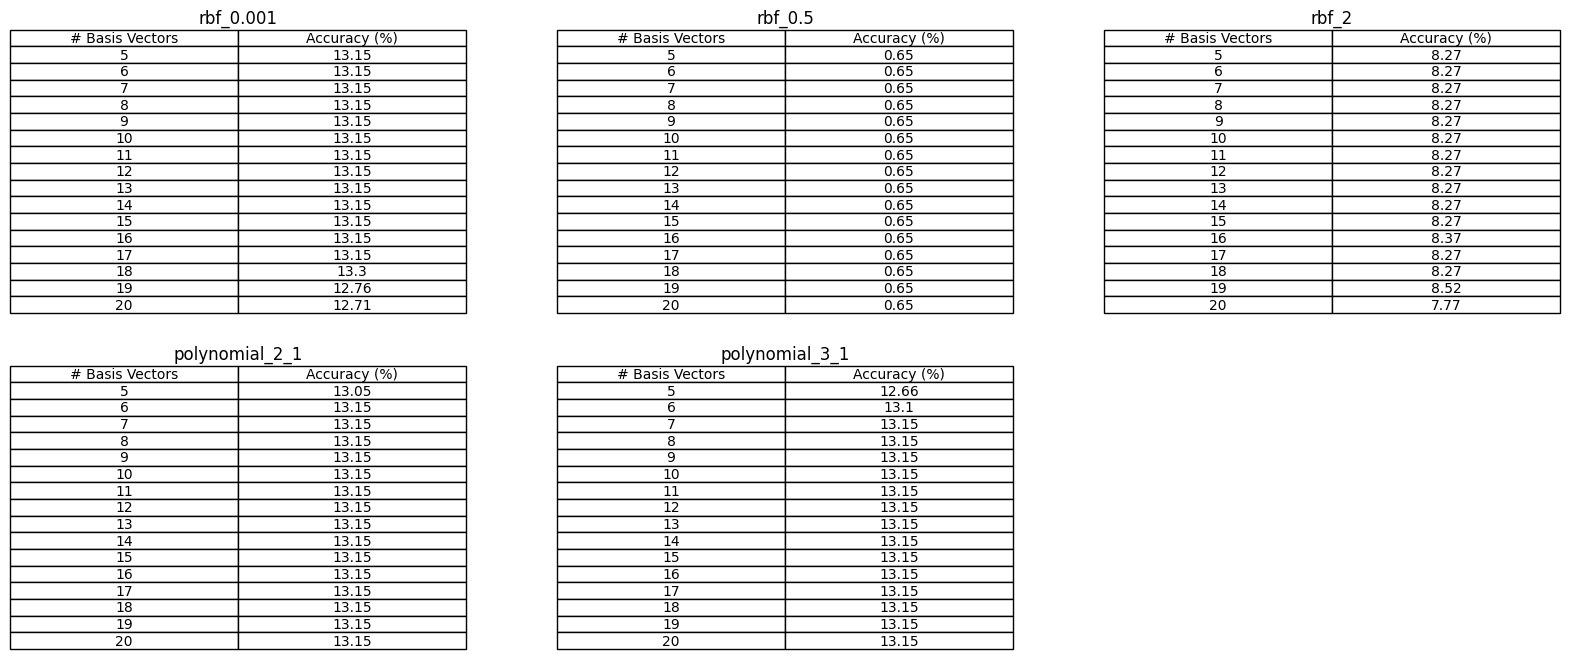

In [118]:
# Creating the subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 8))

# Flattening the axes for easy iteration
axes = axes.flatten()

# Itearating over the results
for index, (title, value) in enumerate(kernel_results.items()):

    # Selecting the corresponding subplot
    ax = axes[index]

    # Creating the table
    ax.table(
        colLabels=["# Basis Vectors", "Accuracy (%)"],
        cellText=[
            [number, round(accuracy * 100, 2)]
            for number, accuracy in value.items()
        ],
        cellLoc="center",
        loc="center",
    )

    # Setting plot parameters
    ax.axis("off")
    ax.set_title(f"{title}")
    ax.grid()

# Removing axes for any unused subplot
axes[5].axis("off")

# Showing
plt.show()

As we can see, the performance is not optimal for any type of kernel, parameter, or number of basis vectors, which may suggest a mistake in my approach or that this type of configuration is not well-suited for the current digit recognition problem